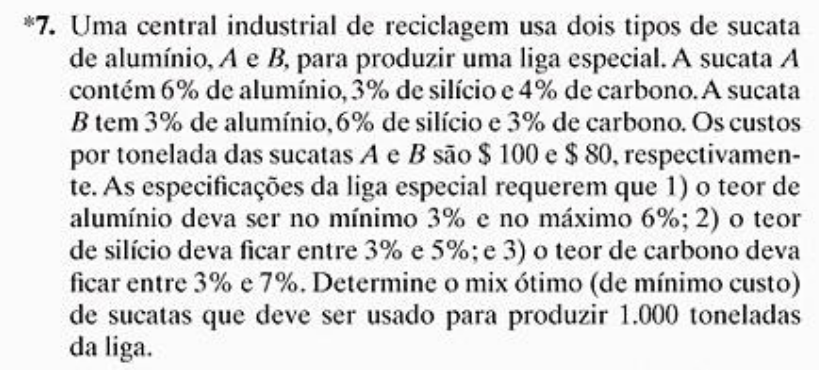

In [1]:
%pip install cplex
%pip install docplex

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from docplex.mp.model import Model

# Criação do modelo com um nome descritivo
model = Model('Mix_Otimo_Reciclagem_Aluminio')

In [3]:
# --- Parâmetros extraídos do enunciado ---

# Tipos de sucata (insumos) e elementos químicos
sucatas = ['A', 'B']
elementos = ['aluminio', 'silicio', 'carbono']

# Produção total necessária
producao_total_liga = 1000 # toneladas

# Custo por tonelada de cada sucata
custo_por_tonelada = {'A': 100, 'B': 80}

# Composição química de cada sucata (em percentual)
composicao_sucata = {
    'A': {'aluminio': 0.06, 'silicio': 0.03, 'carbono': 0.04},
    'B': {'aluminio': 0.03, 'silicio': 0.06, 'carbono': 0.03}
}

# Especificações da liga final (em percentual)
especificacao_liga = {
    'aluminio': {'min': 0.03, 'max': 0.06},
    'silicio':  {'min': 0.03, 'max': 0.05},
    'carbono':  {'min': 0.03, 'max': 0.07}
}

In [4]:
# 1. Variáveis de Decisão
# Toneladas de cada tipo de sucata a serem usadas
toneladas_sucata = model.continuous_var_dict(sucatas, name='Ton')


# 2. Função Objetivo
# Minimizar o custo total da mistura de sucatas
expressao_custo = (custo_por_tonelada[s] * toneladas_sucata[s] for s in sucatas)
custo_total = model.sum(expressao_custo)
model.minimize(custo_total)


# 3. Restrições

# Restrição 1: Produção Total
# A soma das toneladas de sucata A e B deve ser exatamente 1.000 toneladas.
expressao_total_usado = (toneladas_sucata[s] for s in sucatas)
soma_total_usado = model.sum(expressao_total_usado)
restr_prod_total_logica = soma_total_usado == producao_total_liga
model.add_constraint(restr_prod_total_logica, ctname='producao_total')

# Restrição 2: Especificações da Liga (limites mínimo e máximo para cada elemento)
for e in elementos:
    # Quantidade total do elemento 'e' na mistura final
    expressao_elemento = (composicao_sucata[s][e] * toneladas_sucata[s] for s in sucatas)
    soma_total_elemento = model.sum(expressao_elemento)

    # Limite inferior: a quantidade do elemento deve ser >= X% da produção total
    limite_inferior_abs = especificacao_liga[e]['min'] * producao_total_liga
    restr_min_logica = soma_total_elemento >= limite_inferior_abs
    model.add_constraint(restr_min_logica, ctname=f'min_{e}')

    # Limite superior: a quantidade do elemento deve ser <= Y% da produção total
    limite_superior_abs = especificacao_liga[e]['max'] * producao_total_liga
    restr_max_logica = soma_total_elemento <= limite_superior_abs
    model.add_constraint(restr_max_logica, ctname=f'max_{e}')

In [5]:
# Define um tempo limite para o solver (opcional)
model.parameters.timelimit = 120

# Aciona o solver para encontrar a solução
print("--- Resolvendo o modelo ---")
solucao = model.solve(log_output=True)

print('\n------ SOLUÇÃO ÓTIMA ------\n')
print(solucao)

--- Resolvendo o modelo ---
Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               120
Tried aggregator 1 time.
LP Presolve eliminated 6 rows and 1 columns.
Aggregator did 1 substitutions.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.00 ticks)

------ SOLUÇÃO ÓTIMA ------

solution for: Mix_Otimo_Reciclagem_Aluminio
objective: 86666.7
status: OPTIMAL_SOLUTION(2)
Ton_A=333.333
Ton_B=666.667

